# Moving Averages: A Powerful Tool in Data Science

“A moving average (aka. rolling average or running average) is a calculation to analyze data points by creating series of averages of different subsets of the full data set”
In layman’s terms, moving averages “smooth” your data to make trend spotting more obvious.
It is important to note that the length of the subset used in calculating a moving average is fixed. For instance, if time (specifically days) is your independent variable and you’re interested in calculating a rolling 20-day moving average, your subset does not grow to 21 elements one day later. Rather, your subset drops the oldest element and gains a new more recent element — all the while remaining at 20 elements.

Different types of moving averages
Let’s now discuss three different moving averages: Simple Moving Average (SMA), Weighted Moving Average (WMA), and Exponential Moving Average (EMA).
A simple moving average is, simply, the arithmetic mean of your subset. Period.
The weighted moving average follows the same idea of the simple moving average but weights each element of the subset using a linearly increasing (or decreasing) factor. Once the elements are weighted, the weighted moving average returns the simple moving average of the new subset. For example, calculating a X-day weighted moving average could assign a weighting factor of x to the most recent data point, x-1 to next most recent data point, all the way down to 1 for the oldest data point. This method puts a higher value on more recent data.
Similarly to the weighted moving average, the exponential moving average weights each element of the subset. However, the exponential moving average uses an exponentially increasing (or decreasing) weighting factor (see exponential smoothing). This method puts the highest value on more recent data points.

Using moving averages
While moving averages can be used by data scientists in many, many ways (e.g., forecasting seasonality at hotel chains, inventory management at retail warehouses, or real-time patient data analysis in healthcare), the remainder of this blog will focus on the basics of technical analysis as it relates to stock trading.
Moving averages are at the foundation of some of the most complicated trading strategies utilized on the street today. For now, we will keep it simple and explore a relatively common stock price trend indicator called a crossover. To explain what a crossover is, let us consider a M-period moving average, a N-period moving average (let’s assume M > N), an independent variable equal to time (delineated by the same periods used to define the moving averages), and a dependent variable equal to the price of the underlying security we are trying to analyze. A crossover occurs when N’s rolling average price is greater than (or less than) M’s rolling average price. Colloquially, this is called “crossing above (below)”.
A golden cross occurs when the shorter-term moving average (a common short-term moving average in technical analysis is 50-days) crosses above a long-term moving average (a common long-term moving average is 200-days). This is an indication that a stock’s price should increase in the future since the short-term trend has more momentum (i.e., is stronger than) the longer-term trend. A death cross is the opposite: the shorter-term moving average crosses below the longer-term moving average, indicating a loss of positive momentum or a lack of buying support.
    
    



Reference :
    https://medium.com/@jprinfret/moving-averages-a-powerful-tool-in-data-science-67e3b25ce5db

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
df = pd.read_csv('/Users/gkumargaur/workspace/python/gitprojects/Stock-Prediction-Models/dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2020-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2020-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2020-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2020-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [5]:
short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

,signal,short_ma,long_ma,positions
0,0.0,768.700012,768.700012,NaN
1,0.0,765.415008,765.415008,0.0
2,0.0,764.283346,764.283346,0.0
3,0.0,768.842514,768.842514,0.0
4,0.0,773.176013,773.176013,0.0
...,...,...,...,...
247,0.0,976.255005,983.440002,0.0
248,0.0,982.058339,985.941671,0.0
249,0.0,986.876668,988.381668,0.0
250,1.0,994.908335,990.628337,1.0


In [6]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [7]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 6: buy 1 units at price 762.559998, total balance 9237.440002
day 9, sell 1 units at price 758.489990, investment -0.533730 %, total balance 9995.929992,
day 15: buy 1 units at price 760.989990, total balance 9234.940002
day 20, sell 1 units at price 747.919983, investment -1.717501 %, total balance 9982.859985,
day 26: buy 1 units at price 789.289978, total balance 9193.570007
day 37, sell 1 units at price 791.549988, investment 0.286335 %, total balance 9985.119995,
day 45: buy 1 units at price 806.650024, total balance 9178.469971
day 62, sell 1 units at price 798.530029, investment -1.006632 %, total balance 9977.000000,
day 69: buy 1 units at price 819.239990, total balance 9157.760010
day 84, sell 1 units at price 831.909973, investment 1.546553 %, total balance 9989.669983,
day 85: buy 1 units at price 835.369995, total balance 9154.299988
day 96, sell 1 units at price 817.580017, investment -2.129593 %, total balance 9971.880005,
day 104: buy 1 units at price 834.570007, to

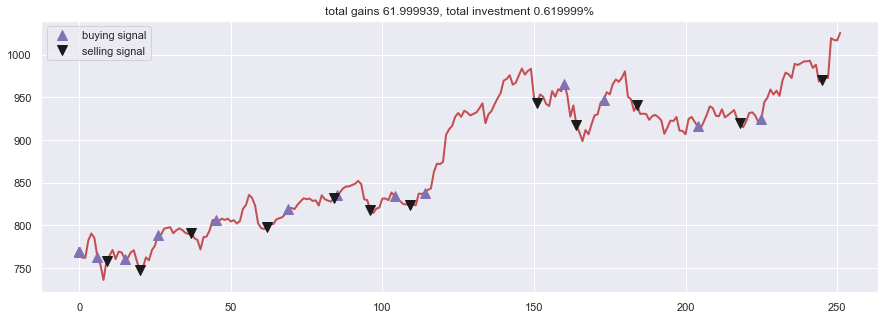

In [8]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()